References:

https://pylessons.com/CartPole-DDDQN/
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://github.com/gouxiangchen/dueling-DQN-pytorch/blob/master/dueling_dqn.py

In [19]:
import gym
import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from plot_durations import PlotDurations

In [20]:
##############################################################
# Memory
##############################################################
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [21]:
##############################################################
# Model
##############################################################
class DDDQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DDDQN, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(n_observations, 64)
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)
        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, n_actions)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(x))
        adv = self.relu(self.fc_adv(x))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            return torch.argmax(Q, dim=1).view(1, 1)

In [22]:
##############################################################
# Training
##############################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("CartPole-v1")

BATCH_SIZE = 512
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10  # each 10 episodes copy policy_net params to target_net
REPLAY_MEMORY = 50000

initial_state = env.reset()
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

policy_net = DDDQN(n_observations, n_actions).to(device)
target_net = DDDQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# optimizer = optim.RMSprop(policy_net.parameters())
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)
memory = ReplayMemory(REPLAY_MEMORY)

steps_done = 0

def select_action(state):  # return tensor([[0]]) or tensor([[1]])
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return policy_net.select_action(state)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [23]:
##############################################################
# Training loop
##############################################################
def optimize_model():
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)  # [[0], [1], [0], [1], ...]
    reward_batch = torch.cat(batch.reward)  # [1, 1, 1, ...]

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
    state_action_values = policy_net(state_batch).gather(1, action_batch)  # [[.2], [.3], ...]

    # Compute V(s_{t+1}) for all next states. Computed based on the "older" target_net
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()  # [.2, .3, ...]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch  # [1.02, 1.03, ...]

    # Compute Huber loss
    # F.smooth_l1_loss([.2, .3, ...], [1.02, 1.03, ...])
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

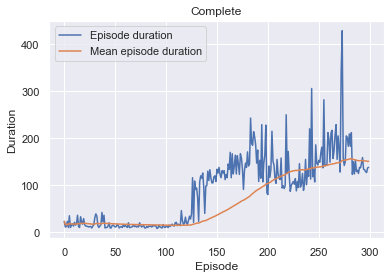

In [24]:
episode_durations = []
num_episodes = 300
start_point = None
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)  # [1.0]

        # Observe new state
        if not done:
            next_state = torch.tensor(next_state, device=device, dtype=torch.float).unsqueeze(0)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        if len(memory) > BATCH_SIZE:
            if start_point is None:
                start_point = (i_episode, t)
            optimize_model()

        if done:
            episode_durations.append(t + 1)
            PlotDurations.train_plot(episode_durations)
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

env.close()
torch.save(target_net.state_dict(), 'model-dql.pt')

PlotDurations.complete_plot(episode_durations)

In [25]:
print('Train start at {} episode, {} step'.format(*start_point))

Train start at 30 episode, 2 step


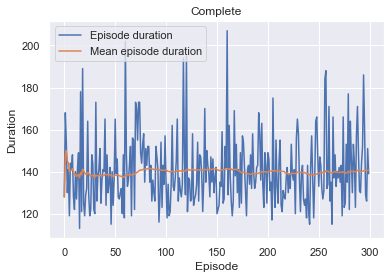

In [26]:
num_episodes = 80
episode_durations = []
for i_episode in range(num_episodes):
    state = torch.tensor(env.reset(), device=device, dtype=torch.float).unsqueeze(0)
    for t in count():
        # Select and perform an action
        action = target_net.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)  # [1.0]
        # Move to the next state
        state = torch.tensor(next_state, device=device, dtype=torch.float).unsqueeze(0)

        if done:
            episode_durations.append(t + 1)
            PlotDurations.train_plot(episode_durations)
            break

env.close()
PlotDurations.complete_plot(episode_durations)